In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/epl1718/EPL2017-18.xlsx


Pythagorean Expectation is a metric that evaluates a team’s number of runs for and runs against and attempts to use that data to come up with what a team’s win percentage “should” be base on run data alone.
It is assumed that over a longer period of time (for example a baseball season), win/loss percentage should correlate with run data based on the Pythagorean expectation formula.
Pythagorean expectation can be used to determine if a team is ahead or behind where it “should” be based on run data. A team strongly lagging Pythagorean expectation is seen through this filter as due for a win streak, while one strongly ahead of it is seen as due for a losing streak.
In practice, Pythagorean win percentage has shown to be quite accurate – usually being off by 2 – 3 wins over the course of a baseball season. Alternative forms of Pythagorean win percentage use a different exponent than 2.

Formula
Pythagorean Win = Runs Scored2/(Runs Scored2 + Runs Allowed2)
It can also calculate as:
Pythagorean Win = 1 / (1 + (Runs Allowed / Runs Scored)2)

In [2]:

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install xlrd

     |████████████████████████████████| 96 kB 385 kB/s 


In [4]:
!pip install openpyxl

     |████████████████████████████████| 243 kB 416 kB/s 


In [5]:
EPL18 = pd.read_excel('../input/epl1718/EPL2017-18.xlsx')
print(EPL18.columns.tolist())

['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']


In [6]:
EPL18.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,20170811,Arsenal,Leicester,4,3,H
1,20170812,Brighton,Man City,0,2,A
2,20170812,Chelsea,Burnley,2,3,A
3,20170812,Crystal Palace,Huddersfield,0,3,A
4,20170812,Everton,Stoke,1,0,H


In [7]:
# We first identify whether the result was a win for the home team (H),
# the away team (A) or a draw (D). We also create the counting variable.

EPL18['hwinvalue']=np.where(EPL18['FTR']=='H',1,np.where(EPL18['FTR']=='D',.5,0))
EPL18['awinvalue']=np.where(EPL18['FTR']=='A',1,np.where(EPL18['FTR']=='D',.5,0))
EPL18['count']=1

In [8]:
Epl17 = EPL18[EPL18["Date"] < 20180000]
Epl18 = EPL18[EPL18["Date"] >= 20180000]
Epl17.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,hwinvalue,awinvalue,count
0,20170811,Arsenal,Leicester,4,3,H,1.0,0.0,1
1,20170812,Brighton,Man City,0,2,A,0.0,1.0,1
2,20170812,Chelsea,Burnley,2,3,A,0.0,1.0,1
3,20170812,Crystal Palace,Huddersfield,0,3,A,0.0,1.0,1
4,20170812,Everton,Stoke,1,0,H,1.0,0.0,1


In [9]:
# we have to create separate dfs to calculate home team and away team performance
# Here is the home team df, including only the variables we need.
Epl17home = Epl17.groupby(['HomeTeam'])['count','hwinvalue', 'FTHG','FTAG'].sum().reset_index()
Epl17home = Epl17home.rename(columns={'HomeTeam':'team','count':'Ph','FTHG':'FTHGh','FTAG':'FTAGh'})
Epl17home.head()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,team,Ph,hwinvalue,FTHGh,FTAGh
0,Arsenal,10,8.5,25,10
1,Bournemouth,11,4.5,14,17
2,Brighton,10,5.5,10,12
3,Burnley,10,6.0,7,6
4,Chelsea,11,8.5,21,7


In [10]:
# Now we create the mirror image df for the away team results.
Epl17away = Epl17.groupby(['AwayTeam'])['count','awinvalue', 'FTHG','FTAG'].sum().reset_index()
Epl17away = Epl17away.rename(columns={'AwayTeam':'team','count':'Pa','FTHG':'FTHGa','FTAG':'FTAGa'})
Epl17away.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,team,Pa,awinvalue,FTHGa,FTAGa
0,Arsenal,11,5.0,16,13
1,Bournemouth,10,3.0,15,6
2,Brighton,11,3.0,13,5
3,Burnley,11,6.5,11,11
4,Chelsea,10,7.0,7,18


In [11]:
Pl = pd.merge(Epl17home,Epl17away,on=["team"])
Pl.head()

,team,Ph,hwinvalue,FTHGh,FTAGh,Pa,awinvalue,FTHGa,FTAGa
0,Arsenal,10,8.5,25,10,11,5.0,16,13
1,Bournemouth,11,4.5,14,17,10,3.0,15,6
2,Brighton,10,5.5,10,12,11,3.0,13,5
3,Burnley,10,6.0,7,6,11,6.5,11,11
4,Chelsea,11,8.5,21,7,10,7.0,7,18


In [12]:
# Sum the results by home and away measures to get the team overall performance for the season
Pl["w"] = Pl["hwinvalue"] + Pl["awinvalue"]
Pl["G"] = Pl["Ph"] + Pl["Pa"]
Pl["GF"] = Pl["FTHGh"] + Pl["FTAGa"]
Pl["GA"] = Pl["FTHGa"] + Pl["FTAGh"]
Pl.sort_values('w',ascending = False)

,team,Ph,hwinvalue,FTHGh,FTAGh,Pa,awinvalue,FTHGa,FTAGa,w,G,GF,GA
10,Man City,10,9.5,36,7,11,10.5,5,25,20.0,21,61,12
4,Chelsea,11,8.5,21,7,10,7.0,7,18,15.5,21,39,14
11,Man United,11,9.0,24,5,10,6.5,11,19,15.5,21,43,16
9,Liverpool,11,8.5,21,4,10,6.5,20,27,15.0,21,48,24
0,Arsenal,10,8.5,25,10,11,5.0,16,13,13.5,21,38,26
16,Tottenham,10,7.5,21,8,10,5.5,12,18,13.0,20,39,20
3,Burnley,10,6.0,7,6,11,6.5,11,11,12.5,21,18,17
6,Everton,10,6.5,17,13,11,3.5,19,8,10.0,21,25,32
8,Leicester,10,5.0,13,14,11,5.0,18,18,10.0,21,31,32
7,Huddersfield,11,6.0,10,12,10,3.0,20,8,9.0,21,18,32


In [13]:
# Create the win percentage and Pythagorean Expectation
Pl['wpc17'] = Pl['w']/Pl['G']
Pl["pyth17"] = Pl["GF"]**2/(Pl["GF"]**2+Pl["GA"]**2)
Pl.head()


,team,Ph,hwinvalue,FTHGh,FTAGh,Pa,awinvalue,FTHGa,FTAGa,w,G,GF,GA,wpc17,pyth17
0,Arsenal,10,8.5,25,10,11,5.0,16,13,13.5,21,38,26,0.642857,0.681132
1,Bournemouth,11,4.5,14,17,10,3.0,15,6,7.5,21,20,32,0.357143,0.280899
2,Brighton,10,5.5,10,12,11,3.0,13,5,8.5,21,15,25,0.404762,0.264706
3,Burnley,10,6.0,7,6,11,6.5,11,11,12.5,21,18,17,0.595238,0.528548
4,Chelsea,11,8.5,21,7,10,7.0,7,18,15.5,21,39,14,0.738095,0.885847


In [14]:
Pl['diff'] = Pl['pyth17'] - Pl['wpc17']
Pl.sort_values("awinvalue",ascending = False)

,team,Ph,hwinvalue,FTHGh,FTAGh,Pa,awinvalue,FTHGa,FTAGa,w,G,GF,GA,wpc17,pyth17,diff
10,Man City,10,9.5,36,7,11,10.5,5,25,20.0,21,61,12,0.952381,0.962743,0.010362
4,Chelsea,11,8.5,21,7,10,7.0,7,18,15.5,21,39,14,0.738095,0.885847,0.147752
3,Burnley,10,6.0,7,6,11,6.5,11,11,12.5,21,18,17,0.595238,0.528548,-0.066690
11,Man United,11,9.0,24,5,10,6.5,11,19,15.5,21,43,16,0.738095,0.878385,0.140290
9,Liverpool,11,8.5,21,4,10,6.5,20,27,15.0,21,48,24,0.714286,0.800000,0.085714
16,Tottenham,10,7.5,21,8,10,5.5,12,18,13.0,20,39,20,0.650000,0.791775,0.141775
8,Leicester,10,5.0,13,14,11,5.0,18,18,10.0,21,31,32,0.476190,0.484131,0.007941
0,Arsenal,10,8.5,25,10,11,5.0,16,13,13.5,21,38,26,0.642857,0.681132,0.038275
17,Watford,11,4.5,14,23,10,4.5,14,16,9.0,21,30,37,0.428571,0.396651,-0.031921
6,Everton,10,6.5,17,13,11,3.5,19,8,10.0,21,25,32,0.476190,0.379018,-0.097173


In the diff column ,you can see the difference between the win percentage and P.E .Thus you can say whether a team is ahead or behind from where it should be

In [15]:
Epl18home = Epl18.groupby(['HomeTeam'])['count','hwinvalue', 'FTHG','FTAG'].sum().reset_index()
Epl18home = Epl18home.rename(columns={'HomeTeam':'team','count':'Ph1','FTHG':'FTHGh1','FTAG':'FTAGh1','hwinvalue':'hwinvalue1'})
Epl18home.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,team,Ph1,hwinvalue1,FTHGh1,FTAGh1
0,Arsenal,9,7.5,29,10
1,Bournemouth,8,5.0,12,13
2,Brighton,9,5.5,14,13
3,Burnley,9,3.5,9,11
4,Chelsea,8,4.5,9,9


In [16]:
Epl18away = Epl18.groupby(['AwayTeam'])['count','awinvalue', 'FTHG','FTAG'].sum().reset_index()
Epl18away = Epl18away.rename(columns={'AwayTeam':'team','count':'Pa1','FTHG':'FTHGa1','FTAG':'FTAGa1','awinvalue':'awinvalue1'})
Epl18away.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,team,Pa1,awinvalue1,FTHGa1,FTAGa1
0,Arsenal,8,1.0,15,7
1,Bournemouth,9,4.0,16,13
2,Brighton,8,1.5,16,5
3,Burnley,8,4.0,11,9
4,Chelsea,9,4.5,15,14


In [17]:
Pl18 = pd.merge(Epl18home,Epl18away,on=["team"])
Pl18.head()

,team,Ph1,hwinvalue1,FTHGh1,FTAGh1,Pa1,awinvalue1,FTHGa1,FTAGa1
0,Arsenal,9,7.5,29,10,8,1.0,15,7
1,Bournemouth,8,5.0,12,13,9,4.0,16,13
2,Brighton,9,5.5,14,13,8,1.5,16,5
3,Burnley,9,3.5,9,11,8,4.0,11,9
4,Chelsea,8,4.5,9,9,9,4.5,15,14


In [18]:
Pl18["w1"] = Pl18["hwinvalue1"] + Pl18["awinvalue1"]
Pl18["G1"] = Pl18["Ph1"] + Pl18["Pa1"]
Pl18["GF1"] = Pl18["FTHGh1"] + Pl18["FTAGa1"]
Pl18["GA1"] = Pl18["FTHGa1"] + Pl18["FTAGh1"]

In [19]:
Pl18.sort_values('w1',ascending = False)

,team,Ph1,hwinvalue1,FTHGh1,FTAGh1,Pa1,awinvalue1,FTHGa1,FTAGa1,w1,G1,GF1,GA1
10,Man City,9,7.5,25,7,8,6.5,8,20,14.0,17,45,15
16,Tottenham,9,7.5,19,8,9,6.5,8,16,14.0,18,35,16
11,Man United,8,7.0,14,4,9,5.5,8,11,12.5,17,25,12
9,Liverpool,8,7.0,24,6,9,5.0,8,12,12.0,17,36,14
12,Newcastle,8,6.0,12,4,9,3.0,13,8,9.0,17,20,17
1,Bournemouth,8,5.0,12,13,9,4.0,16,13,9.0,17,25,29
19,West Ham,10,6.0,14,12,8,3.0,18,12,9.0,18,26,30
5,Crystal Palace,8,4.5,15,9,9,4.5,14,12,9.0,17,27,23
4,Chelsea,8,4.5,9,9,9,4.5,15,14,9.0,17,23,24
0,Arsenal,9,7.5,29,10,8,1.0,15,7,8.5,17,36,25


In [20]:
Pl18['wpc18'] = Pl18['w1']/Pl18['G1']
Pl18["pyth18"] = Pl18["GF1"]**2/(Pl18["GF1"]**2+Pl18["GA1"]**2)
Pl18.head()


,team,Ph1,hwinvalue1,FTHGh1,FTAGh1,Pa1,awinvalue1,FTHGa1,FTAGa1,w1,G1,GF1,GA1,wpc18,pyth18
0,Arsenal,9,7.5,29,10,8,1.0,15,7,8.5,17,36,25,0.500000,0.674649
1,Bournemouth,8,5.0,12,13,9,4.0,16,13,9.0,17,25,29,0.529412,0.426330
2,Brighton,9,5.5,14,13,8,1.5,16,5,7.0,17,19,29,0.411765,0.300333
3,Burnley,9,3.5,9,11,8,4.0,11,9,7.5,17,18,22,0.441176,0.400990
4,Chelsea,8,4.5,9,9,9,4.5,15,14,9.0,17,23,24,0.529412,0.478733


Here , you can see the diff in performances at home and away

In [21]:
Pl18['d'] = Pl18['hwinvalue1'] - Pl18['awinvalue1']
Pl18

,team,Ph1,hwinvalue1,FTHGh1,FTAGh1,Pa1,awinvalue1,FTHGa1,FTAGa1,w1,G1,GF1,GA1,wpc18,pyth18,d
0,Arsenal,9,7.5,29,10,8,1.0,15,7,8.5,17,36,25,0.500000,0.674649,6.5
1,Bournemouth,8,5.0,12,13,9,4.0,16,13,9.0,17,25,29,0.529412,0.426330,1.0
2,Brighton,9,5.5,14,13,8,1.5,16,5,7.0,17,19,29,0.411765,0.300333,4.0
3,Burnley,9,3.5,9,11,8,4.0,11,9,7.5,17,18,22,0.441176,0.400990,-0.5
4,Chelsea,8,4.5,9,9,9,4.5,15,14,9.0,17,23,24,0.529412,0.478733,0.0
5,Crystal Palace,8,4.5,15,9,9,4.5,14,12,9.0,17,27,23,0.529412,0.579491,0.0
6,Everton,9,5.5,11,9,8,2.5,17,8,8.0,17,19,26,0.470588,0.348120,3.0
7,Huddersfield,8,2.5,6,13,9,2.5,13,4,5.0,17,10,26,0.294118,0.128866,0.0
8,Leicester,9,5.0,12,8,8,2.5,20,13,7.5,17,25,28,0.441176,0.443577,2.5
9,Liverpool,8,7.0,24,6,9,5.0,8,12,12.0,17,36,14,0.705882,0.868633,2.0


In [22]:
Pl1718 = pd.merge(Pl,Pl18,on=["team"])
Pl1718.head()

,team,Ph,hwinvalue,FTHGh,FTAGh,Pa,awinvalue,FTHGa,FTAGa,w,...,awinvalue1,FTHGa1,FTAGa1,w1,G1,GF1,GA1,wpc18,pyth18,d
0,Arsenal,10,8.5,25,10,11,5.0,16,13,13.5,...,1.0,15,7,8.5,17,36,25,0.500000,0.674649,6.5
1,Bournemouth,11,4.5,14,17,10,3.0,15,6,7.5,...,4.0,16,13,9.0,17,25,29,0.529412,0.426330,1.0
2,Brighton,10,5.5,10,12,11,3.0,13,5,8.5,...,1.5,16,5,7.0,17,19,29,0.411765,0.300333,4.0
3,Burnley,10,6.0,7,6,11,6.5,11,11,12.5,...,4.0,11,9,7.5,17,18,22,0.441176,0.400990,-0.5
4,Chelsea,11,8.5,21,7,10,7.0,7,18,15.5,...,4.5,15,14,9.0,17,23,24,0.529412,0.478733,0.0


We can see a kind of relation between wp and PE but it is not very evident due to the lack of datapoints

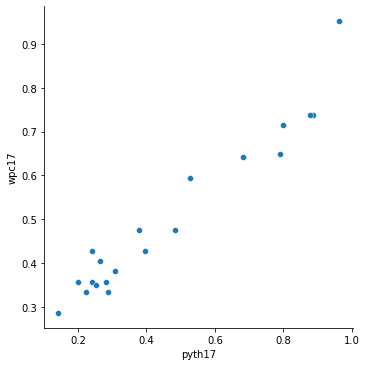

In [23]:
sns.relplot(x="pyth17", y="wpc17", data =Pl)

In [24]:

pyth_lm = smf.ols(formula = 'wpc17 ~ pyth17', data=Pl).fit()
pyth_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  wpc17   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     269.6
Date:                Fri, 11 Jun 2021   Prob (F-statistic):           2.81e-12
Time:                        13:51:01   Log-Likelihood:                 33.822
No. Observations:                  20   AIC:                            -63.64
Df Residuals:                      18   BIC:                            -61.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1978      0.021      9.335      0.000       0.153       0.242
pyth17         0.6551      0.040     16.420      0.000       0.571       0.739
==============================================================================
Omnibus:                        6.775   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                4.322
Skew:                           1.048   Prob(JB):                        0.115
Kurtosis:                       3.891   Cond. No.                         4.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

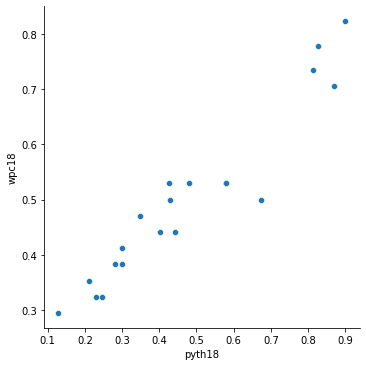

In [25]:
sns.relplot(x="pyth18", y="wpc18", data =Pl18)

In [26]:
pyth_lm = smf.ols(formula = 'wpc18 ~ pyth18', data=Pl18).fit()
pyth_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  wpc18   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     191.1
Date:                Fri, 11 Jun 2021   Prob (F-statistic):           5.02e-11
Time:                        13:51:02   Log-Likelihood:                 34.030
No. Observations:                  20   AIC:                            -64.06
Df Residuals:                      18   BIC:                            -62.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2040      0.024      8.586      0.000       0.154       0.254
pyth18         0.6237      0.045     13.823      0.000       0.529       0.718
==============================================================================
Omnibus:                        5.199   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                2.933
Skew:                          -0.826   Prob(JB):                        0.231
Kurtosis:                       3.890   Cond. No.                         5.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# The two plots look similar
# We can be more precise still if we compare the correlation coefficients. The first row of the table shows the 
# correlation of win percentage in second half of the season against itself, win percentage in the first half of the season,
# Pythagorean Expectation in the first half of the season, and Pythagorean Expectation in the second half of the season.
# Our focus is on comparing the second and third columns.

keyvars = Pl1718[['team','wpc18','wpc17','pyth17','pyth18']]
keyvars.corr()

,wpc18,wpc17,pyth17,pyth18
wpc18,1.000000,0.756573,0.795693,0.955986
wpc17,0.756573,1.000000,0.968204,0.745832
pyth17,0.795693,0.968204,1.000000,0.795331
pyth18,0.955986,0.745832,0.795331,1.000000


We can see from the correlation matrix that win percentage in the second half of the season is correlated with win percentage in the first half of the season - the correlation coefficient. It's not surprising that performance in the first half of the season is to an extent predictive of performance in the second half. But there are also clearly things that can change.
We could simply use first half win percentage as a predictor of second half win percentage, but when we look at the correlation matrix we can see that the Pythagorean Expectation is an even better forecast - the correlation coefficient is higher. To be sure, the difference is not large, but it is slightly better. This was, in fact, the initial impetus for Bill James when introducing the statistic. He argued that a win could ride on lucky hit and the difference of just one run, which made wins a less reliable predictor than the aggregate capacity to produce runs and limit conceding runs. As in many aspects of baseball analysis, our data show that James was quite right.Similar thought process could be applied in football

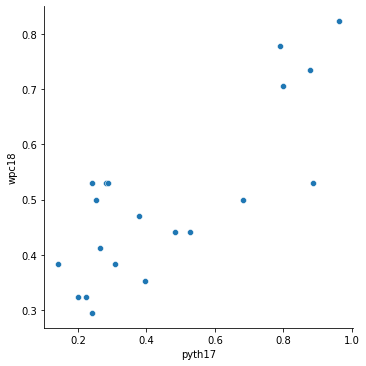

In [28]:
sns.relplot(x="pyth17", y="wpc18", data =Pl1718)

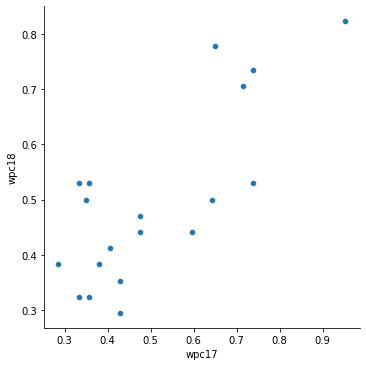

In [29]:
sns.relplot(x="wpc17", y="wpc18", data =Pl1718)

When we run our regression, again, we look at the coefficient on Pythagorean expectation, we have a value for the coefficient and we can see it's statistically highly significant. We have a very large T-statistic and a p-value again. When we look at the R squared up here, we can see an R squared of 0.9 for which tells us that our Pythagorean expectation is capturing a very large fraction, almost all the variation in lead position that we can find. What we've shown this time is that, even if we look at a very different competition we look at the world of soccer, we still find the same relationship we found in baseball and basketball which is telling us really this Pythagorean expectation seems to be a fairly common feature of all sports and the only outlier appears to be cricket data